In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
TRAIN_TEST_SPLIT = 3000
SHUFFER_BUFFER_SIZE = 1000

In [3]:
WINDOW_SIZE = 60
BATCH_SIZE = 32

In [4]:
data_path = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir=''
)

In [5]:
df_data = pd.read_csv(data_path, index_col=0)
df_data.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [6]:
time = df_data.index.to_numpy()
series = df_data['Monthly Mean Total Sunspot Number'].to_numpy()

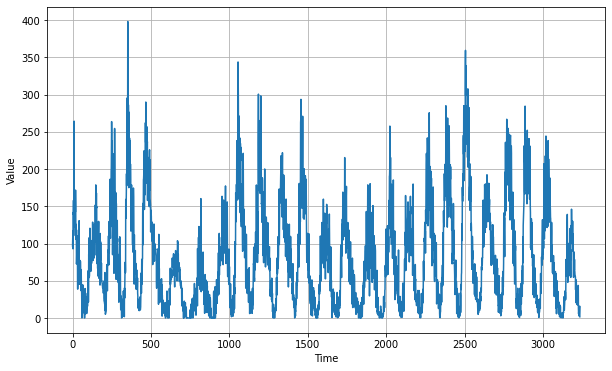

In [7]:
utils.plot_series(time, series)

In [8]:
time_train = time[:TRAIN_TEST_SPLIT]
x_train = series[:TRAIN_TEST_SPLIT]
time_val = time[TRAIN_TEST_SPLIT:]
x_val = series[TRAIN_TEST_SPLIT:]

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
def build_model(lr=1e-8):
    model = keras.models.Sequential([
        keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1),
    ])

    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [11]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [12]:
keras.backend.clear_session()

model = build_model(1e-7)

history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
92/92 [==============================] - 0s 4ms/step - loss: 1804.9467 - mae: 30.8819
Epoch 2/100
92/92 [==============================] - 0s 4ms/step - loss: 1127.8756 - mae: 24.9641
Epoch 3/100
92/92 [==============================] - 0s 4ms/step - loss: 1033.7037 - mae: 23.8384
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 962.8425 - mae: 23.0164
Epoch 5/100
92/92 [==============================] - 0s 5ms/step - loss: 907.7850 - mae: 22.2970
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 871.4866 - mae: 21.8821
Epoch 7/100
92/92 [==============================] - 0s 4ms/step - loss: 850.3923 - mae: 21.5201
Epoch 8/100
92/92 [==============================] - 0s 5ms/step - loss: 834.6146 - mae: 21.3713
Epoch 9/100
92/92 [==============================] - 0s 5ms/step - loss: 801.5830 - mae: 20.8592
Epoch 10/100
92/92 [==============================] - 0s 4ms/step - loss: 780.9346 - mae: 20.6271
Epoch 11/100
92/92 [======

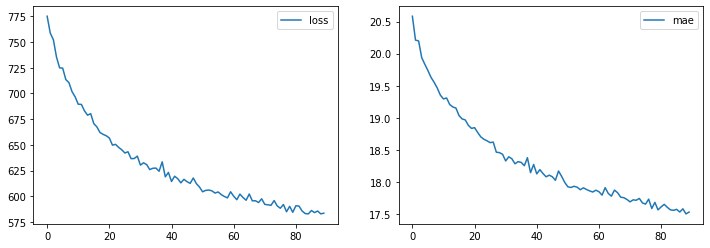

In [13]:
utils.plot_history(history, metrics=['loss', 'mae'], start=10)

mse = 424.5481, mae = 14.6899


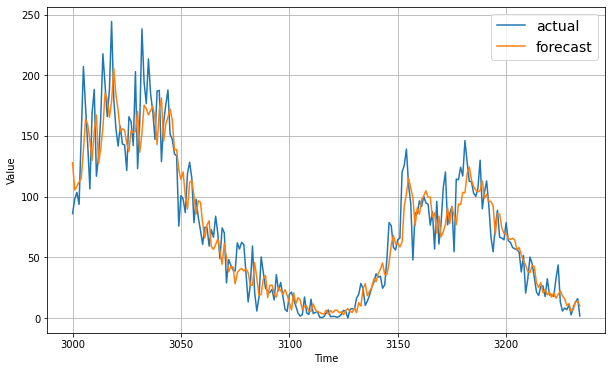

In [14]:
forecasts = []
for t in time_val:
    x = series[t-WINDOW_SIZE:t]
    forecast = model.predict(np.expand_dims(x, 0))[0][0]
    forecasts.append(forecast)

utils.evaluate(x_val, forecasts)

utils.plot_series(time_val, [x_val, forecasts], label=['actual', 'forecast'])